# Enterprise Deep Learning with TensorFlow: openSAP

## SAP Innovation Center Network

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Overview

This notebook makes use of Tensorflow's new Estimator API and the new Dataset API.
Both APIs are widely used within Google. They simplify and standardize model building.

The Estimator API.

tf.estimator.Estimator:  
An 'estimator' takes as input some 'model' function along with some custom parameters.  
It wraps the training loop, evaluation loop & prediction stage.  
  
  def model_fn(features, labels, mode, params):  
     ...
     setup network graph for training, evaluation, and prediction mode  
     define loss & training operator  
     define what the network outputs / predicts  
     define accuracy measures  
  
     return tf.estimator.EstimatorSpec(loss, mode, predictions, train_op, eval_metric_ops, training_hooks)  

  estimator = tf.estimator.Estimator(model_fn, params, config)
  
  def train_input_fn():  
      return features, labels   # tensors  
  
  estimator.train(train_input_fn)  
  
  
  def validation_input_fn():  
      return features, labels   # tensors  
  
  estimator.evaluate(validation_input_fn)  
  
  result = estimator.predict(predict_input_fn)  
  
  for output in result:  
  
      do_something_with(output)

## Loading the necessary modules

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Setting up our environment

In [2]:
# Our output/log directory
LOG_DIR = './rnn_output'
# The number of steps in each training sequence
# (i.e. our sequence length)
TIMESTEPS = 5
# The number of hidden units in the RNN layer
RNN_NUM_UNITS = 10
# The number of hidden units in the two additional fully connected layers
DENSE_LAYERS = [10, 10]
# The number of training iterations
TRAINING_STEPS = 10000
# The number of training features we are going to train in parallel
# (to speed things up)
BATCH_SIZE = 100
# How often do we want to do screen / file log output
PRINT_STEPS = TRAINING_STEPS / 1000
# Our learning rate
# If too large, training can become unstable.
# If too small, training might converge too slowly or not to an optimium.
LEARNING_RATE = 1e-3

# The RunConfig object that is used by our Estimator (see below).
# Among other things, this is useful for setting the output / logging directory
# as well as the output frequency.
run_config = tf.estimator.RunConfig()
run_config = run_config.replace(model_dir=LOG_DIR, save_summary_steps=PRINT_STEPS)

## Creating our data set

In [3]:
# The raw data: This is simply a sine function, i.e. one long sequence
# of scalar values.
xx = np.linspace(0, 100, 10000)
raw_data = np.sin(xx)

# Let's split this into train/validation data
# We take the first 80% of elements in the sequence
# as training elements, and the remaining as validation elements.
N = int(raw_data.shape[0] * 0.8)
train_data = raw_data[:N]
valid_data = raw_data[N:]

# During training, we don't actually work on the entire sequence at once.
# In most cases this would be computationally prohibitive.
# Rather, we split up the sequence into many small sub-sequences.
# One single input feature becomes a subsequence of N elements.
# Based on that input sequence, the network shall learn to predict the next
# element following that sequence.
# The associated training label to any input sequence
# therefore is the next value coming right after the last element in the input sequence.
# This routine returns exactly that!
# From large raw sequence [0,1,2,3,4,5,6,7,8,9], we get a list of subsequences with associated
# label.
#  E.g.  --->
#  list of input features: [[0,1,2], [1,2,3], [2,3,4], ..., [6,7,8]]
#  list of associated labels: [3, 4, 5, ..., 9]
def make_rnn_data(data):

    # 'data' is one large 1D numpy array.

    # Make a list of 1D numpy arrays
    features = [data[i:i + TIMESTEPS] for i in range(data.shape[0] - TIMESTEPS)]
    # Make a list of scalars
    labels = [data[i + TIMESTEPS] for i in range(data.shape[0] - TIMESTEPS)]

    # Let's convert the lists to numpy arrays.
    features = np.asarray(features)
    labels = np.asarray(labels)

    return features, labels

## Input routine

In [4]:
# This routine returns a (features, labels) tuple
# of tensors. These tensors are fed by Tensorflow's dataset API using the
# train_samples data set generated above.
def train_input():

    # Let's convert the raw training data to (features, label) pairs
    features, labels = make_rnn_data(train_data)

    num_training_samples = features.shape[0]

    # We use the numpy feature, label arrays to generate a Tensorflow dataset.
    # This dataset is a source of training samples
    dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(features, dtype=tf.float32),
                                                          tf.constant(labels, dtype=tf.float32)))

    # Let's repeat samples from the dataset indefinitly
    dataset = dataset.repeat()
    # Let's shuffle training samples. This will improve training because the network will
    # see individual training samples in random order and grouped in random batches.
    dataset = dataset.shuffle(num_training_samples)
    # Let's finally batch individual samples to groups of BATCH_SIZE samples
    # This is what the network will receive as input.
    dataset = dataset.batch(BATCH_SIZE)

    # Finally, create a one shot iterator for the dataset.
    # The iterator is used for accessing the individual elements from the dataset
    iterator = dataset.make_one_shot_iterator()

    # Get the shuffled and batched samples from the dataset
    # This actually returns tensors.
    features, labels = iterator.get_next()

    return (features, labels)

# Same as above, but for validation data.
# Only some subtle differences
def valid_input():

    features, labels = make_rnn_data(valid_data)

    dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(features, dtype=tf.float32),
                                                          tf.constant(labels, dtype=tf.float32)))

    dataset = dataset.batch(BATCH_SIZE)

    # Note: we do not need to shuffle!

    iterator = dataset.make_one_shot_iterator()

    features, labels = iterator.get_next()

    return (features, labels)

## Some TensorFlow helper classes and functions

In [5]:
class OutputHook(tf.train.SessionRunHook):

    def __init__(self, name, log_dir=None, logged_tensors={}, save_steps=100):

        self._logdir = log_dir
        self._logged_tensors = logged_tensors
        self._save_steps = save_steps
        self._name = name

    def begin(self):
        # Let's get the 'global_step' tensor.
        # The Tensorflow estimator will create this tensor to log / control
        # the training.
        # We need it to know at which training step we are.
        self._global_step_tensor = tf.train.get_global_step()
        self._logged_tensors['step'] = self._global_step_tensor

    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
        """
        return tf.train.SessionRunArgs(fetches=self._logged_tensors)

    def after_run(self, run_context, run_values):
        """ This routine is run directly after a training step (i.e. a session.run call).
            Since we returned a 'SessionRunArgs' object in the before_run routine above,
            This routine will receive a dictionary of results of the evaluated tensors (in "run_values").
            Here, we are interested in outputting those results to a text ascii file.
        """

        if run_values.results['step'] % self._save_steps:
            return

        fp = open(self._logdir+'/'+self._name+'.txt', 'a')

        fp.write(str(run_values.results['step']))
        del run_values.results['step']

        for key in run_values.results:
            fp.write(' '+str(run_values.results[key]))
        fp.write('\n')
        fp.close()

## The Recurrent Neural Network

This part defines our recurrent neural network.

In [6]:
# This routine sets up the network and defines the cost function / optimizer that
# is used during training. It also defines what the network is actually predicting.
# The 'features' and 'labels' arguments are mandatory. The remaining arguments are optional and can be used
# to further control the behavior of this function.
def rnn_model(features, labels, mode, params, config):

    # Let's define a simple vanilla RNN "cell".
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(params['rnn_num_units'])

    # Our input features are batches of entire sequences right now, ie.e matrices of shape [batch_size x sequence_length].
    # However, the network needs to be unrolled and look at each element in the sequence sequentially.
    # This is what happens here: from a tensor of shape [batch_size x sequence_length]
    # we generate a list of tensors [[batch_size], .... ]
    x_ = tf.unstack(features, params['timesteps'], axis=1)
    # Even though each element in our sequence is just a batch of scalars at this stage (i.e. shape [batch_size]),
    # Tensorflow wants us to still have the tensors of shape [batch_size x 1].
    x_ = [ tf.reshape(x, (-1,1)) for x in x_ ]
    # Let's actually create a RNN layer that is unrolled over the individual elements of the sequence.
    output, layers = tf.nn.static_rnn(rnn_cell, x_, dtype=tf.float32)

    # Let's also attach some final non-recurrent fully connected layers after the RNN  layer.
    output = slim.fully_connected(output[-1], num_outputs=10, activation_fn=tf.nn.relu)
    output = slim.fully_connected(output, num_outputs=10, activation_fn=tf.nn.relu)
    # This is the finaly regression layer (no non-linearity!)
    # It just contains one unit since we want to regress exactly one single scalar value.
    output = slim.fully_connected(output, num_outputs=1, activation_fn=None)
    # We need to remove the last axis which is of dimension 1 (due to the single unit in the last fully connected layer)
    # i.e. tensor of shape [batch_size, 1] is transformed to a tensor of shape
    # [batch_size]
    # This is our final network output (a batch of scalars)
    output = tf.squeeze(output)

    train_op = None
    loss = None

    if mode != tf.estimator.ModeKeys.PREDICT:
        # This is the loss / cost function we aim to minimize!
        # Since we want the network to learn to predict/regress the next element in the sequence,
        # the loss is the mean squared distance between the label and the prediction (i.e. the network output)
        loss = tf.losses.mean_squared_error(labels, output)

    if mode == tf.estimator.ModeKeys.TRAIN:
        print ('Setting up model for training mode!')
        optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        # Let's monitor the loss
        tf.summary.scalar('loss', loss)

    predictions = {
        'prediction': output,
    }
    eval_metric_ops = None
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "accuracy": tf.metrics.mean_squared_error(labels, predictions["prediction"])
        }
        # Let's monitor the accuracy for evaluation
        tf.summary.scalar('accuracy', eval_metric_ops['accuracy'])


    training_hooks = []

    if mode != tf.estimator.ModeKeys.PREDICT:
        summary = tf.summary.merge_all()
        # This will create and write output summaries to Tensorboard
        summary_hook = tf.train.SummarySaverHook(save_steps=config.save_summary_steps, summary_op=summary)
        # Let's also use our custom output hook to write the training loss to ascii file
        output_hook = OutputHook(name='training', log_dir=config.model_dir, logged_tensors={'loss' : loss}, save_steps=config.save_summary_steps)

        training_hooks.append(summary_hook)
        training_hooks.append(output_hook)

    # The model function must return a EstimatorSpec object
    # The EstimatorSpec object wraps the loss, train_op, hooks, etc...
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op,
                                      predictions=predictions,
                                      eval_metric_ops=eval_metric_ops,
                                      training_hooks=training_hooks)

## Training and Evaluation

In [7]:
# Let's setup our estimator!
# An estimator requires a model function
regressor = tf.estimator.Estimator(model_fn=rnn_model,
                                   params={'learning_rate' : LEARNING_RATE,
                                           'timesteps' : TIMESTEPS,
                                           'rnn_num_units' : RNN_NUM_UNITS},
                                   config=run_config)



# Set the logging verbosity
tf.logging.set_verbosity(tf.logging.INFO)

# Execute the training using 'train_input' as the training input function!
regressor.train(train_input, steps=TRAINING_STEPS)

# Execute validation using 'valid_input' as the validation input function
regressor.evaluate(valid_input)


# Let's get a python generator of network prediction.
# At this point, the network will not be evaluated!
# It will only be evaluated once we explicitly ask for it!
generator = regressor.predict(valid_input)

# Let's open an ascii text file to write the predictions
fp = open(LOG_DIR+'/prediction.txt', 'w')

# Let's loop over the generator and get the results for each
# sample in the validation set!
results = []
for i, result in enumerate(generator):

    results.append(result["prediction"])
    fp.write(str(i+N+TIMESTEPS)+' '+str(result['prediction'])+'\n')

fp.close()


fp = open(LOG_DIR+'/raw_data.txt', 'w')
for i in range(raw_data.shape[0]):
    fp.write(str(i)+' '+str(raw_data[i])+'\n')
fp.close()

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 1.0, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': './rnn_output', '_tf_random_seed': 1, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
Setting up model for training mode!
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./rnn_output/model.ckpt-10001
INFO:tensorflow:Saving checkpoints for 10002 into ./rnn_output/model.ckpt.
INFO:tensorflow:step = 10002, loss = 1.87844e-06
INFO:tensorflow:global_step/sec: 289.303
INFO:tensorflow:step = 10102, loss = 1.68586e-06 (0.357 sec)
INFO:tensorflow:global_step/sec: 295.947
INFO:tensorflow:step = 10202, loss = 3.57554e-06 (0.333 sec)
INFO:tensorflow:global_step/sec: 218.102
INFO:tensorflow:step = 10302, loss = 1.08265e-06 (0.456 sec)
INFO:tensorflow:global_step/sec: 254.933
INFO:tensorflow:step = 10402, loss = 1.98661e-06 (0.398 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 207.406
INFO:tensorflow:step = 17602, loss = 9.01123e-07 (0.475 sec)
INFO:tensorflow:global_step/sec: 241.808
INFO:tensorflow:step = 17702, loss = 3.47785e-06 (0.416 sec)
INFO:tensorflow:global_step/sec: 254.761
INFO:tensorflow:step = 17802, loss = 1.28353e-06 (0.396 sec)
INFO:tensorflow:global_step/sec: 275.132
INFO:tensorflow:step = 17902, loss = 6.78446e-07 (0.361 sec)
INFO:tensorflow:global_step/sec: 269.539
INFO:tensorflow:step = 18002, loss = 6.77713e-07 (0.376 sec)
INFO:tensorflow:global_step/sec: 220.346
INFO:tensorflow:step = 18102, loss = 9.38722e-07 (0.445 sec)
INFO:tensorflow:global_step/sec: 286.022
INFO:tensorflow:step = 18202, loss = 1.40485e-06 (0.349 sec)
INFO:tensorflow:global_step/sec: 283.005
INFO:tensorflow:step = 18302, loss = 1.8091e-06 (0.361 sec)
INFO:tensorflow:global_step/sec: 222.7
INFO:tensorflow:step = 18402, loss = 8.72477e-07 (0.443 sec)
INFO:tensorflow:global_step/sec: 227.483
INFO:tensorflow:step = 18502, loss = 1.22329

<IPython.core.display.Javascript object>


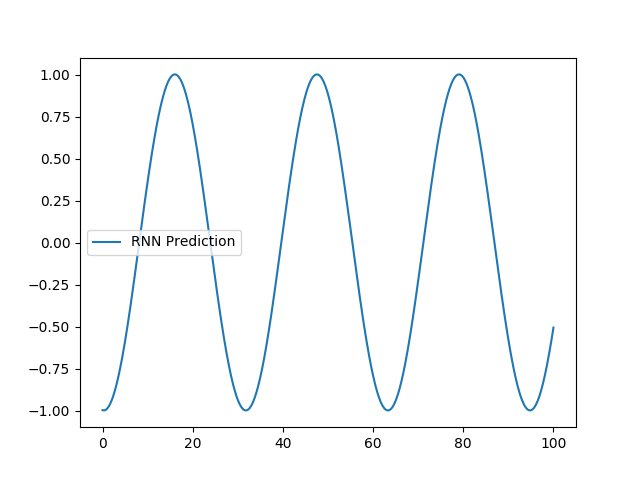

In [15]:
plt.show()